# Tabular GAN from Scratch using Pytorch

The below code is a modifications of the [Pytorch DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import os
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('adult.csv')

In [4]:
df_dropped = df.drop('income', axis=1)

In [5]:
categorical_columns = [col for col in df_dropped.columns if df_dropped[col].dtype == 'object']
numerical_columns = [col for col in df_dropped.columns if df_dropped[col].dtype in ['int64', 'float64']]

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns),
    ])

In [7]:
X = preprocessor.fit_transform(df_dropped)
y = df['income'].apply(lambda x: 1 if x == '>50K' else 0).values

In [8]:
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

In [9]:
dataset = TensorDataset(X_torch, y_torch)

In [10]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [13]:
noise_dim = 100
generator = Generator(input_dim=noise_dim, output_dim=X.shape[1])
discriminator = Discriminator(input_dim=X.shape[1])

In [14]:
criterion = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=0.00040376804222956743)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=2.019033675863192e-05)

The basic training loop for the GAN should look as following

In [18]:
epochs = 25

# Lists to keep track of progress
record_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(epochs):
    for i, batch in enumerate(dataloader, 0):
        # Update Discriminator with Real Data
        discriminator.zero_grad()
        real_data, _ = batch
        real_labels = torch.ones(real_data.size(0), 1)
        output_real = discriminator(real_data)
        loss_real = criterion(output_real, real_labels)

        # Update Discriminator with Fake Data
        noise = torch.randn(real_data.size(0), noise_dim)
        fake_data = generator(noise)
        fake_labels = torch.zeros(real_data.size(0), 1)
        output_fake = discriminator(fake_data.detach())
        loss_fake = criterion(output_fake, fake_labels)

        # Combine Losses for discriminator and Update
        loss_disc = loss_real + loss_fake
        loss_disc.backward()
        optimizer_discriminator.step()

        # Update Generator
        generator.zero_grad()
        output = discriminator(fake_data)
        loss_gen = criterion(output, real_labels)
        loss_gen.backward()
        optimizer_generator.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader), loss_disc.item(), loss_gen.item(), output_real.mean().item(), output_fake.mean().item(), output.mean().item()))

        # Save Losses for plotting later
        G_losses.append(loss_gen.item())
        D_losses.append(loss_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(noise).detach().cpu()
            record_list.append(fake)

        iters += 1

# Save models for each trial temporarily
model_dir = f'../experiments/vanilla_gan/model/vanillaGAN'
os.makedirs(model_dir, exist_ok=True)
torch.save(generator.state_dict(), os.path.join(model_dir, 'generator.pth'))
torch.save(discriminator.state_dict(), os.path.join(model_dir, 'discriminator.pth'))

[0/25][0/1018]	Loss_D: 1.3880	Loss_G: 0.6486	D(x): 0.5231	D(G(z)): 0.5229 / 0.5228
[0/25][50/1018]	Loss_D: 1.3952	Loss_G: 0.6333	D(x): 0.5308	D(G(z)): 0.5331 / 0.5308
[0/25][100/1018]	Loss_D: 1.2159	Loss_G: 0.8140	D(x): 0.5352	D(G(z)): 0.4461 / 0.4431
[0/25][150/1018]	Loss_D: 1.5410	Loss_G: 0.5193	D(x): 0.5354	D(G(z)): 0.6000 / 0.5949
[0/25][200/1018]	Loss_D: 1.3104	Loss_G: 0.7030	D(x): 0.5367	D(G(z)): 0.4974 / 0.4951
[0/25][250/1018]	Loss_D: 1.2206	Loss_G: 0.8161	D(x): 0.5329	D(G(z)): 0.4463 / 0.4421
[0/25][300/1018]	Loss_D: 0.9815	Loss_G: 1.2250	D(x): 0.5337	D(G(z)): 0.2976 / 0.2938
[0/25][350/1018]	Loss_D: 1.1652	Loss_G: 0.9235	D(x): 0.5233	D(G(z)): 0.4031 / 0.3971
[0/25][400/1018]	Loss_D: 1.2634	Loss_G: 0.7881	D(x): 0.5240	D(G(z)): 0.4594 / 0.4547
[0/25][450/1018]	Loss_D: 1.2046	Loss_G: 0.8159	D(x): 0.5429	D(G(z)): 0.4477 / 0.4422
[0/25][500/1018]	Loss_D: 1.0462	Loss_G: 1.0509	D(x): 0.5448	D(G(z)): 0.3551 / 0.3496
[0/25][550/1018]	Loss_D: 0.7934	Loss_G: 1.6949	D(x): 0.5572	D(G(z)):

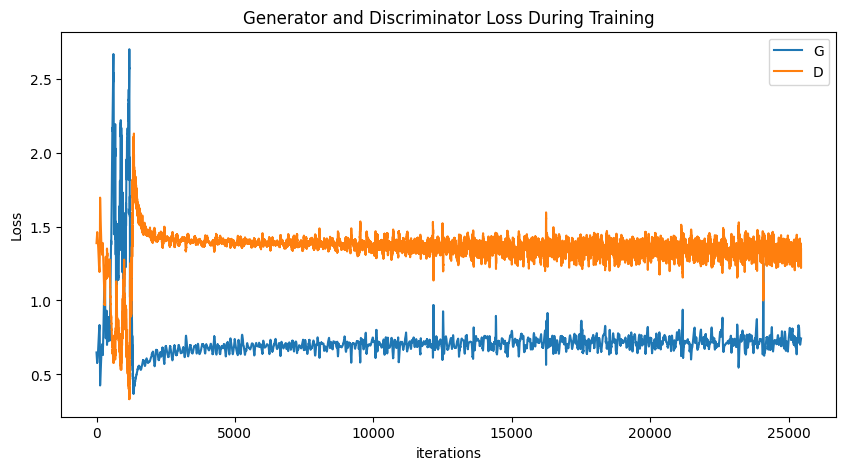

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
from sklearn.svm import OneClassSVM
import numpy as np

# Train SVM on the entire dataset assuming it's mostly normal data
svm_model = OneClassSVM(kernel='rbf', gamma='auto').fit(X)




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_gan_with_svm(generator, discriminator, dataloader, svm_model, epochs=100):
    criterion = nn.BCELoss()
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    optimizer_gen = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=0.0002)
    iters = 0

    for epoch in range(epochs):
        for i, batch in enumerate(dataloader, 0):
            iters += 1
            # Update Discriminator with Real Data
            discriminator.zero_grad()
            real_data, _ = batch
            real_labels = torch.ones(real_data.size(0), 1,device=device)
            real_data = real_data.to(device)
            real_data_np = real_data.cpu().numpy()

            svm_preds = svm_model.predict(real_data_np)

            normal_data = torch.tensor(real_data_np[svm_preds == 1], dtype=torch.float32)

            if len(normal_data) == 0:
                continue  # Skip this batch if all data are outliers

            output_real = discriminator(real_data)
            loss_real = criterion(output_real, real_labels)
            # Update Discriminator with Fake Data
            #real_labels = torch.ones(len(normal_data), 1, device=device)
            #fake_labels = torch.zeros(n_data, 1, device=device)
            noise = torch.randn(real_data.size(0), noise_dim,device=device)
            fake_data = generator(noise)
            fake_labels = torch.zeros(real_data.size(0), 1,device=device)
            output_fake = discriminator(fake_data.detach())
            loss_fake = criterion(output_fake, fake_labels)

            # Combine Losses for discriminator and Update
            loss_disc = loss_real + loss_fake
            loss_disc.backward()
            optimizer_discriminator.step()

            # Update Generator
            generator.zero_grad()
            output = discriminator(fake_data)
            loss_gen = criterion(output, real_labels)
            #loss_gen.backward()
            #optimizer_generator.step()

            fake_data_np = fake_data.detach().cpu().numpy()  # Move generated data to CPU for SVM prediction
            svm_preds_gen = svm_model.predict(fake_data_np)
            svm_preds_gen_df = svm_model.score_samples(fake_data_np)
            anomalies = np.mean(svm_preds_gen_df)
            loss_gen += 0.1 * anomalies
            loss_gen.backward()
            optimizer_gen.step()
            if i % 50 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss D: {loss_disc.item():.4f}, Loss G: {loss_gen.item():.4f}, Anomalies: {anomalies} tD(x): {output_real.mean().item():.4f},  D(G(z)): {output_fake.mean().item():.4f} / {output.mean().item():.4f}')



# Initialize and train
generator = Generator(input_dim=100, output_dim=X.shape[1])
discriminator = Discriminator(input_dim=X.shape[1])
train_gan_with_svm(generator, discriminator, dataloader, svm_model)

Using device: cuda
Epoch [1/100], Loss D: 1.3855, Loss G: 1390.0292, Anomalies: 13892.937981792627 tD(x): 0.4805,  D(G(z)): 0.4793 / 0.4793
Epoch [1/100], Loss D: 1.5043, Loss G: 703.7114, Anomalies: 7030.918231928533 tD(x): 0.4810,  D(G(z)): 0.5381 / 0.5381
Epoch [1/100], Loss D: 1.5196, Loss G: 600.9155, Anomalies: 6003.076665479741 tD(x): 0.4804,  D(G(z)): 0.5446 / 0.5446
Epoch [1/100], Loss D: 1.5256, Loss G: 569.9163, Anomalies: 5693.131772130039 tD(x): 0.4803,  D(G(z)): 0.5471 / 0.5471
Epoch [1/100], Loss D: 1.5250, Loss G: 562.5861, Anomalies: 5619.836708095864 tD(x): 0.4809,  D(G(z)): 0.5475 / 0.5475
Epoch [1/100], Loss D: 1.5264, Loss G: 565.7969, Anomalies: 5651.949259237537 tD(x): 0.4805,  D(G(z)): 0.5477 / 0.5477
Epoch [1/100], Loss D: 1.5264, Loss G: 573.4055, Anomalies: 5728.039430196909 tD(x): 0.4808,  D(G(z)): 0.5480 / 0.5480
Epoch [1/100], Loss D: 1.5292, Loss G: 571.9359, Anomalies: 5713.349513420724 tD(x): 0.4798,  D(G(z)): 0.5483 / 0.5483
Epoch [1/100], Loss D: 1.52

## Hyperparameter Finetuning

Initial experiments on 50 epochs with some initial parameters show a lot of the expected behaviours such as early fluctations in losses.

However, the discriminator loss seems to decrease, while the generator loss seems to increase most of the times (though, not necessarily in an oscillation manner, which would somewhat be expected). The discriminator loss reaches a point where it becomes really small, like the generator loss increases towards a loss of 5.

As a way to experiment with other parameters to see its performance, we'll utilize Optuma's Hyperparameter optimizer to potentially find better hyperparameters.

**Note**: Do not run when implementing basic

In [ ]:
def optuna_optimize(trial, X, dataloader):
    # Define Hyperparameters to optimize
    lr_gen = trial.suggest_float('lr_gen', 1e-5, 1e-3)
    lr_disc = trial.suggest_float('lr_disc', 1e-5, 1e-3)

    # Initialize Models
    generator = Generator(input_dim=100, output_dim=X.shape[1])
    discriminator = Discriminator(input_dim=X.shape[1])

    # Optimizers
    criterion = nn.BCELoss()
    optimizer_gen = optim.Adam(generator.parameters(), lr=lr_gen)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc)

    epochs = 10

    for epoch in range(epochs):
        for i, (data, _) in enumerate(dataloader):
            # Number of data points
            n_data = data.size(0)

            # Train Discriminator
            real_data = data
            real_labels = torch.ones(n_data, 1)
            fake_labels = torch.zeros(n_data, 1)

            discriminator.zero_grad()
            output_real = discriminator(real_data)
            loss_real = criterion(output_real, real_labels)

            noise = torch.randn(n_data, 100)
            fake_data = generator(noise)
            output_fake = discriminator(fake_data.detach())
            loss_fake = criterion(output_fake, fake_labels)

            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_disc.step()

            generator.zero_grad()
            output = discriminator(fake_data)
            loss_g = criterion(output, real_labels)
            loss_g.backward()
            optimizer_gen.step()

    # Example metric to optimize could be the last generator loss
    metric_to_optimize = loss_g.item()

    # Save models for each trial temporarily
    trial_model_dir = f'../experiments/vanilla_gan/hyperparam/trial_{trial.number}_models'
    os.makedirs(trial_model_dir, exist_ok=True)
    torch.save(generator.state_dict(), os.path.join(trial_model_dir, 'generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join(trial_model_dir, 'discriminator.pth'))

    return metric_to_optimize

In [ ]:
# After optimization, save best models more permanently
def save_best_models(study, temporary_dir_base='../experiments/vanilla_gan/hyperparam/trial_'):
    best_trial = study.best_trial.number
    best_model_dir = f'{temporary_dir_base}{best_trial}_models'
    permanent_model_dir = '../experiments/vanilla_gan/hyperparam/best_models'
    os.makedirs(permanent_model_dir, exist_ok=True)

    for filename in ['generator.pth', 'discriminator.pth']:
        os.rename(os.path.join(best_model_dir, filename), os.path.join(permanent_model_dir, filename))

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: optuna_optimize(trial, X, dataloader), n_trials=20)

[I 2024-04-09 11:39:01,595] A new study created in memory with name: no-name-c6e01eb7-64e8-48d2-9c69-ff55177fcbc6
[I 2024-04-09 11:41:33,780] Trial 0 finished with value: 3.9634597301483154 and parameters: {'lr_gen': 0.0005823623488330192, 'lr_disc': 0.0005330975301795992}. Best is trial 0 with value: 3.9634597301483154.
[I 2024-04-09 11:45:16,675] Trial 1 finished with value: 0.7557632923126221 and parameters: {'lr_gen': 0.00040376804222956743, 'lr_disc': 2.019033675863192e-05}. Best is trial 1 with value: 0.7557632923126221.
[I 2024-04-09 11:49:17,799] Trial 2 finished with value: 6.742520809173584 and parameters: {'lr_gen': 9.557589328417663e-05, 'lr_disc': 0.0007941945708970818}. Best is trial 1 with value: 0.7557632923126221.
[I 2024-04-09 11:53:03,011] Trial 3 finished with value: 8.19099235534668 and parameters: {'lr_gen': 0.0003946931431209802, 'lr_disc': 0.0008924853452325022}. Best is trial 1 with value: 0.7557632923126221.
[I 2024-04-09 11:55:23,580] Trial 4 finished with va

In [ ]:
# Save the best models after optimization
save_best_models(study)

In [ ]:
from optuna.visualization import plot_parallel_coordinate

# Generate the plot
fig = plot_parallel_coordinate(study)
fig.show()